[data set from kaggle](https://www.kaggle.com/tmdb/tmdb-movie-metadata#tmdb_5000_movies.csv)

### Data Overview
* 2 files - 1 with full cast and crew credits other has movie metadata around the relase, language, popularity etc.
* file 1: credits
    * 4 columns, 4800 movies
    * 1 json of crew id/name/job and 1 json of cast character/actor/gender/id
* file 2: movie metadata
    * continuous variables: release_date, revenue, runtime, vote average (1-10), vote_count
    * categorical variables: genre (json needs parsing), keywords (thems like 'space war' also json), original language (mostly english), plot overview, production company, production_countries, 

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from pandas.io.json import json_normalize
import json

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, roc_auc_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, cross_val_score

import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
def json_decode(data):
    movie_id_list = []
    credit_id_list = []
    department_list = []
    job_list = []    

    for n in np.arange(len(data)):
        json_cell = json.loads(data['crew'][n]) #convert to jsonjsonn from string
        for item in json_cell: #convert to list from json
            movie_id_list.append(data['movie_id'][n])
            credit_id_list.append(str(item['credit_id']))
            department_list.append(str(item['department']))
            job_list.append(str(item['job']))
        
    result = pd.DataFrame(data={'movie_id':movie_id_list,
                                'department':department_list,
                                'credit_id':credit_id_list,
                                'job':job_list})
                                   
    return result

In [16]:
# import credits file
df_credits = pd.DataFrame(pd.read_csv('tmdb/tmdb_5000_credits.csv'))

# import movie file
df_movies = pd.DataFrame(pd.read_csv('tmdb/tmdb_5000_movies.csv'))
df_movies = df_movies.rename(columns={'id':'movie_id'})
df_movies = df_movies[['movie_id','title','release_date','budget','revenue', 
                       'popularity','vote_average', 'vote_count']]

# Shuffle Dataset
df_movies['random_number'] = np.random.rand(len(df_movies['movie_id']),1)
df_movies = df_movies.sort_values(by='random_number').set_index(['movie_id'])

# parse credits file
df_parsed = json_decode(df_credits)

In [18]:
# Total Crew Count for each movie_id
output_employee = df_parsed.groupby(['movie_id']).count()['job'].reset_index()
output_employee = output_employee.rename(columns={'job':'total_crew'})
output_employee = output_employee.set_index(['movie_id'])

df_movies = df_movies.join(output_employee, how='inner', on='movie_id', rsuffix='_employee')

In [19]:
df_movies['budget_sqrt'] = np.sqrt(df_movies['budget']) 
df_movies['revenue_sqrt'] = np.sqrt(df_movies['revenue']) 
df_movies['popularity_sqrt'] = np.sqrt(df_movies['popularity']) 
df_movies['vote_count_sqrt'] = np.sqrt(df_movies['vote_count']) 

In [20]:
df_movies.columns

Index(['title', 'release_date', 'budget', 'revenue', 'popularity',
       'vote_average', 'vote_count', 'random_number', 'total_crew',
       'budget_sqrt', 'revenue_sqrt', 'popularity_sqrt', 'vote_count_sqrt'],
      dtype='object')

In [21]:
# calculate pivot parsed jobs and count

job_count = df_parsed.pivot_table(index=['movie_id'], 
                                  columns=['job'], 
                                  aggfunc='count', 
                                  fill_value=0)['credit_id']

job_count = df_movies.join(job_count, on='movie_id', how='inner')

#job_count['random_number'] = np.random.rand(4775,1)
#job_count = job_count.sort_values(by='random_number')

# Regression of non job features

#### Additional features I may want to create would be year released or month release. Movies are released seasonally so summer movies may be inherently more popular since they have been specially selected for a summer release. Year may matter if the movie database was constructed ater the movie was released. Art ages strangely, some films are lauded at release but do not age well while other are hated at first and become more liked over time. The second half of that pattern is only captured for movies released before the database was created. On one hand newer movies will have had less time to accumulate reviews. 

Trying out a base level linear regression

In [24]:
import statsmodels.formula.api as smf

In [30]:
# using all of the non job features in a vanilla regression
# I think it's weird to scale after adding square roots to try to normalize
# but not positive
X = df_movies[['budget', 'revenue', 'popularity', 'vote_count',
              'total_crew', 'budget_sqrt', 'revenue_sqrt', 
               'popularity_sqrt', 'vote_count_sqrt']]
y = df_movies['vote_average']

lr = LinearRegression()

# create a fitted model
lm1 = smf.ols(formula='vote_average ~ budget + revenue + popularity + vote_count \
              + total_crew + budget_sqrt + revenue_sqrt +  popularity_sqrt + vote_count_sqrt', data=df_movies).fit()

# print the coefficients
print(lm1.params)

# print rsquared
print(lm1.rsquared)

Intercept          5.244462e+00
budget            -5.500345e-09
revenue            5.446445e-10
popularity        -7.381311e-03
vote_count        -1.563081e-04
total_crew        -1.315830e-03
budget_sqrt       -2.169738e-05
revenue_sqrt      -2.043846e-05
popularity_sqrt    1.828629e-01
vote_count_sqrt    3.870182e-02
dtype: float64
0.2200435243311588


In [32]:
# using all of the non job features in a vanilla regression
# I think it's weird to scale after adding square roots to try to normalize
# but not positive
X = df_movies[['budget', 'revenue', 'popularity', 'vote_count',
              'total_crew']]
y = df_movies['vote_average']

#lr = LinearRegression()

# create a fitted model
lm1 = smf.ols(formula='vote_average ~ budget + revenue + popularity + vote_count \
              + total_crew', data=df_movies).fit()

# print the coefficients
print(lm1.params)

# print rsquared
print(lm1.rsquared)

Intercept     5.922735e+00
budget       -4.577498e-09
revenue      -2.197756e-10
popularity    2.991602e-03
vote_count    3.263538e-04
total_crew    1.751829e-03
dtype: float64
0.12291299709320869


## Sci-kit Learn forced me to use negative mean squared error rather than mean square error, this prevents me from using root mean square error.

In [38]:
# using all of the non job features in a vanilla regression
# I think it's weird to scale after adding square roots to try to normalize
# but not positive
X = df_movies[['budget', 'revenue', 'popularity', 'vote_count',
              'total_crew']]
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
y = df_movies['vote_average']

lr = LinearRegression()

# Cross Validation
print('Negative Mean Square Error: {}'.format(
    cross_val_score(lr, X, y, cv=5, scoring='neg_mean_squared_error')))
      
print('R-Squared: {}'.format(
    cross_val_score(lr, X, y, cv=5, scoring='r2')))      

Negative Mean Square Error: [-1.14763184 -1.26680955 -1.0965349  -1.23311471 -1.03547735]
R-Squared: [0.1147571  0.12265968 0.11215563 0.10419142 0.15125085]


In [ ]:
# root mean square error reports in the metrics of the y units
#np.sqrt(metrics.mean_squared_error(y_true, y_pred))

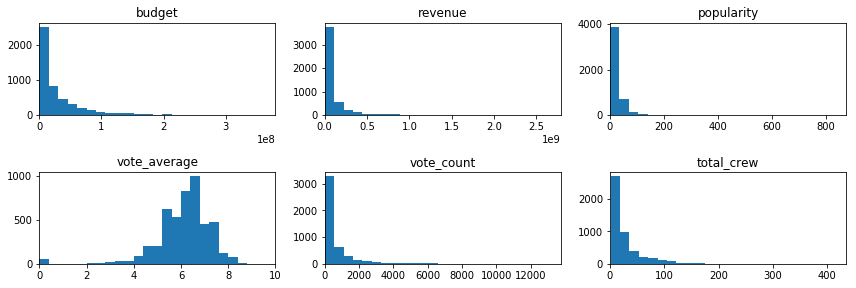

In [9]:
continuous = ['budget', 'revenue', 'popularity', 'vote_average', 'vote_count', 'total_crew']
plt.figure(figsize=(12,8))
n = 0

for x in continuous:    
    n=n+1
    plt.subplot(4,3,n)
    plt.hist(df_movies[x], bins=25)
    plt.xlim(0,df_movies[x].max())
    plt.xlabel('')
    plt.ylabel('')
    
    plt.title(x)
plt.tight_layout()
plt.show()

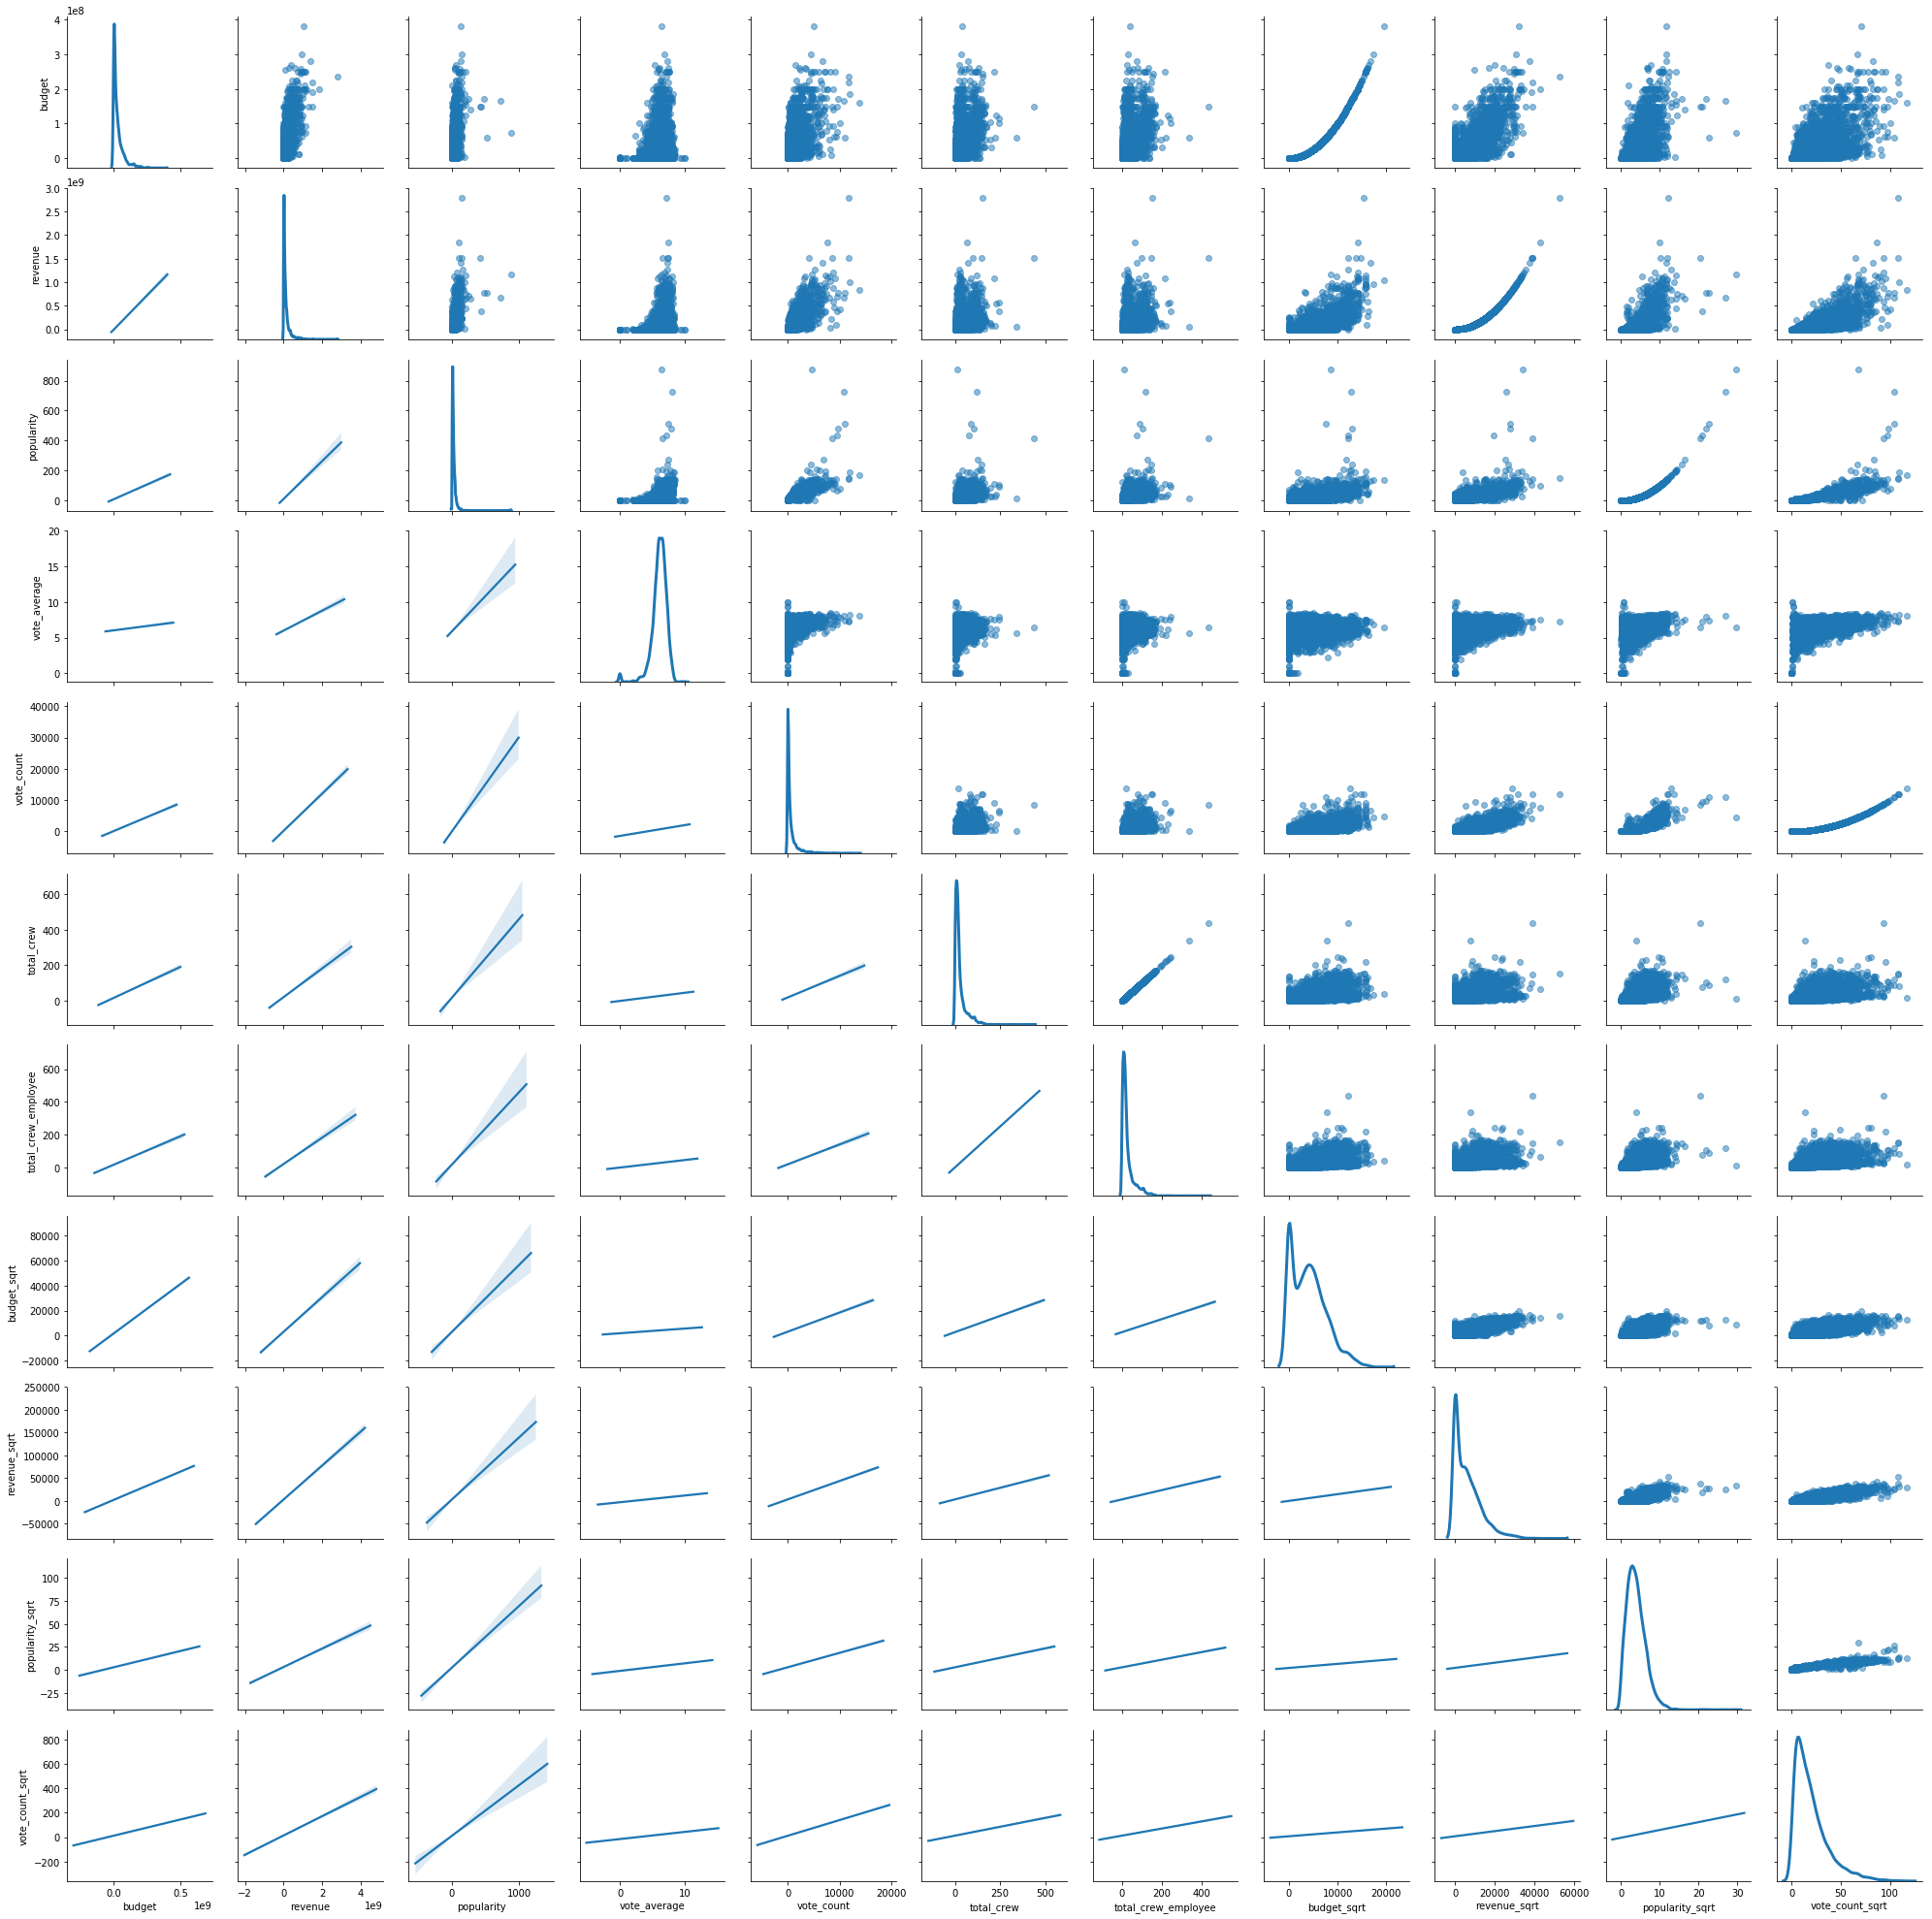

In [73]:
g = sns.PairGrid(df_movies.dropna(), diag_sharey=False)
g.map_upper(plt.scatter, alpha=.5)
g.map_lower(sns.regplot, scatter_kws=dict(alpha=0))
g.map_diag(sns.kdeplot,lw=3)
plt.show()

In [11]:
df_movies['total_crew']=df_movies.total_crew.astype('int')

In [13]:
df_movies.columns

Index(['title', 'release_date', 'budget', 'revenue', 'popularity',
       'vote_average', 'vote_count', 'budget_sqrt', 'revenue_sqrt',
       'popularity_sqrt', 'vote_count_sqrt', 'total_crew'],
      dtype='object')

In [ ]:
feature_columns = df_parsed.job.unique()

X = job_count[feature_columns]
y = job_count['vote_average']

lr = LinearRegression()

cross_val_score(lr, X, y, cv=5,)

# Feature Reduction

In [54]:
X = job_count[feature_columns]
y = job_count['vote_average']
X = X.reset_index(drop=True)
y = df_movies['vote_average']
y = y.astype('int')

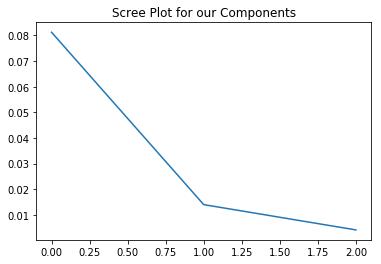

array([0.16563367, 0.16487924, 0.15817033, 0.13674564, 0.19992056])

In [67]:
from sklearn.decomposition import PCA
X = df_movies[['budget', 'revenue', 'popularity',
               'vote_count', 'total_crew', 'budget_sqrt', 
               'revenue_sqrt', 'popularity_sqrt', 'vote_count_sqrt']] 
y = df_movies['vote_average']
y = y.astype('int')

# Scale Data
sklearn_pca = PCA(n_components=3)
pca_feat = X
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(pca_feat)
X_PCA = sklearn_pca.fit_transform(X_normalized)
var_ratios = (list(sklearn_pca.explained_variance_ratio_))
component_variances = (list(sklearn_pca.explained_variance_))
              
# Plotting to decide which features to keep
sorted_eigenvals = sorted(component_variances, reverse=True)
plt.plot(sorted_eigenvals)
plt.title("Scree Plot for our Components")

plt.show()

lr = LinearRegression()

cross_val_score(lr, X_PCA, y, cv=5, scoring='r2')

In [ ]:
plt.show()

print('Percent of variance explained by component \n', var_ratios)
print('\n Eigenvalues: {}'.format(sorted_eigenvals))
chi_selector = SelectKBest(chi2, k=3)
chi_selector.fit(X_norm, y)
chi_support = chi_selector.get_support()
chi_feature = X.loc[:,chi_support].columns.tolist()
print(str(len(chi_feature)), 'selected features')
print(chi_feature)

In [45]:
# using all of the non job features in a vanilla regression
# I think it's weird to scale after adding square roots to try to normalize
# but not positive
X = df_movies[['budget', 'revenue']]
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
y = df_movies['vote_average']

lr = LinearRegression()

# Cross Validation
print('Negative Mean Square Error: {}'.format(
    cross_val_score(lr, X, y, cv=5, scoring='neg_mean_squared_error')))
      
print('R-Squared: {}'.format(
    cross_val_score(lr, X, y, cv=5, scoring='r2'))) 

Negative Mean Square Error: [-1.23350932 -1.3774578  -1.17380291 -1.3537812  -1.14705234]
R-Squared: [0.04851423 0.04602924 0.04959313 0.01653204 0.05979624]


# Try PCA with job vectors

In [60]:
feature_columns = df_parsed.job.unique()

X = job_count[feature_columns]
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
y = job_count['vote_average']
y = y.astype('int')
lr = LinearRegression()

print('Cross Validated R_squared with all jobs:')
print('\n{}'.format(cross_val_score(lr, X, y, cv=5, scoring='r2')))

print('\nCross Validated Neg Mean Squared Error with all jobs:')
print('\n{}'.format(cross_val_score(lr, X, y, cv=5, scoring='neg_mean_squared_error')))

print('Cross Validated R_squared with SCALED jobs:')
print('\n{}'.format(cross_val_score(lr, X_scaled, y, cv=5, scoring='r2')))

print('\nCross Validated Neg Mean Squared Error with SCALED jobs:')
print('\n{}'.format(cross_val_score(lr, X_scaled, y, cv=5, scoring='neg_mean_squared_error')))

Cross Validated R_squared with all jobs:

[-0.09503538 -0.63928064 -0.4899     -0.46658576 -0.21216278]

Cross Validated Neg Mean Squared Error with all jobs:

[-1.43077819 -2.36864167 -1.88783452 -2.06506982 -1.54992295]
Cross Validated R_squared with SCALED jobs:

[-7.09439854e+24 -7.20035688e+09 -4.22915159e+24 -9.78343646e+23
 -6.66836883e+23]

Cross Validated Neg Mean Squared Error with SCALED jobs:

[-9.26957330e+24 -1.04039936e+10 -5.35870753e+24 -1.37758595e+24
 -8.52646034e+23]


In [ ]:
# using all of the non job features in a vanilla regression
# I think it's weird to scale after adding square roots to try to normalize
# but not positive
X = job_count[feature_columns]
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
y = job_count['vote_average']
y = y.astype('int')
lr = LinearRegression()

X = df_movies[['budget', 'revenue', 'popularity', 'vote_count',
              'total_crew']]
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
y = df_movies['vote_average']

lr = LinearRegression()

# Cross Validation
print('Negative Mean Square Error: {}'.format(
    cross_val_score(lr, X, y, cv=5, scoring='neg_mean_squared_error')))
      
print('R-Squared: {}'.format(
    cross_val_score(lr, X, y, cv=5, scoring='r2'))) 

In [15]:
df_movies.columns

Index(['budget', 'genres', 'homepage', 'movie_id', 'keywords',
       'original_language', 'original_title', 'overview', 'popularity',
       'production_companies', 'production_countries', 'release_date',
       'revenue', 'runtime', 'spoken_languages', 'status', 'tagline', 'title',
       'vote_average', 'vote_count'],
      dtype='object')

In [34]:
feature_columns = df_parsed.job.unique()

X = job_count[feature_columns]
y = job_count['vote_average']

lr = LinearRegression()

cross_val_score(lr, X, y, cv=5,)

array([-0.20844303, -1.78651739, -0.33245533, -0.01156281, -0.05211257])

In [68]:
job_count.columns

Index(['title', 'release_date', 'budget', 'revenue', 'popularity',
       'vote_average', 'vote_count', 'random_number', 'total_crew',
       'budget_sqrt',
       ...
       'Visual Effects Designer', 'Visual Effects Editor',
       'Visual Effects Producer', 'Visual Effects Supervisor',
       'Visual Effects Technical Director', 'Vocal Coach',
       'Wardrobe Supervisor', 'Wig Designer', 'Wigmaker', 'Writer'],
      dtype='object', length=431)

In [72]:
# concatenate will try to join on the index, join explicitly 
pd.concat([job_count[feature_columns], df_movies[['budget', 'revenue']]], axis=1)
job_count[feature_columns].join(df_movies[['budget', 'revenue']], on='movie_id', how='inner')

,Editor,Production Design,Sound Designer,Supervising Sound Editor,Casting,Original Music Composer,Director,Writer,Producer,Screenplay,...,Prosthetic Designer,Sound Montage Associate,Radio Play,Key Animation,Mechanical & Creature Designer,Interior Designer,Imaging Science,Settings,budget,revenue
movie_id,,,,,,,,,,,,,,,,,,,,,
4174,0,0,0,0,0,1,1,0,1,1,...,0,0,0,0,0,0,0,0,1500000,7000000
18320,2,1,0,0,1,1,1,1,4,0,...,0,0,0,0,0,0,0,0,35000000,27409889
44944,0,0,0,0,0,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,37000000
8488,2,0,0,0,0,1,1,0,2,1,...,0,0,0,0,0,0,0,0,70000000,368100420
1164,2,1,2,0,0,1,1,0,5,1,...,0,0,0,0,0,0,0,0,25000000,135330182
18892,1,1,0,0,2,0,1,1,2,0,...,0,0,0,0,0,0,0,0,3000000,3076820
133931,0,0,0,0,0,0,1,0,0,3,...,0,0,0,0,0,0,0,0,20000000,0
38428,1,0,0,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
13184,2,1,0,0,1,1,2,0,5,1,...,0,0,0,0,0,0,0,0,45000000,42487390


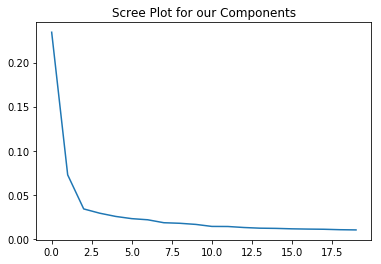

Percent of variance explained by component 
 [0.18066349219854774, 0.05598250306797359, 0.026209249193041854, 0.022468669270781946, 0.019640623778825403, 0.01771364736869863, 0.016715939869999585, 0.014151919278903927, 0.013657085015163165, 0.012672317304877008, 0.010916315719277914, 0.010846254253932383, 0.009965565079122758, 0.009378600941568241, 0.009197304758873481, 0.00881023304663716, 0.008582403770783216, 0.008432411251385469, 0.008041314421559103, 0.007858922810221007]

 Eigenvalues: [0.23436054078596813, 0.07262169868355879, 0.03399919784416114, 0.029146837675729648, 0.025478236660678628, 0.022978521704085174, 0.02168427422721058, 0.018358171952739175, 0.017716262376883854, 0.01643880066991327, 0.014160877907467471, 0.014069992678211574, 0.012927543870425322, 0.012166121454500429, 0.011930940174089438, 0.011428822481695003, 0.011133277478959607, 0.010938703979177627, 0.010431364818274806, 0.010194762524430937]
9 selected features
['Editor', 'Production Design', 'Sound Designer

In [65]:
from sklearn.decomposition import PCA

X = job_count[feature_columns]
y = df_movies['vote_average']
y = y.astype('int')

lr = LinearRegression()

# Scale Data
sklearn_pca = PCA(n_components=20)
pca_feat = X
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(pca_feat)
X_PCA = sklearn_pca.fit_transform(X_normalized)
var_ratios = (list(sklearn_pca.explained_variance_ratio_))
component_variances = (list(sklearn_pca.explained_variance_))
              
# Plotting to decide which features to keep
sorted_eigenvals = sorted(component_variances, reverse=True)
plt.plot(sorted_eigenvals)
plt.title("Scree Plot for our Components")

plt.show()

print('Percent of variance explained by component \n', var_ratios)
print('\n Eigenvalues: {}'.format(sorted_eigenvals))
chi_selector = SelectKBest(chi2, k='all')
chi_selector.fit(X_norm, y)
chi_support = chi_selector.get_support()
chi_feature = X.loc[:,chi_support].columns.tolist()
print(str(len(chi_feature)), 'selected features')
print(chi_feature)

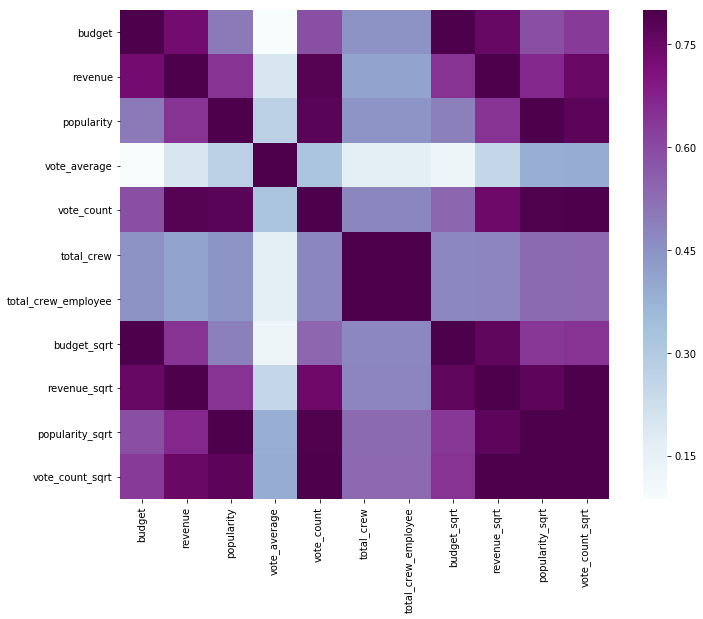

In [72]:
# Make the correlation matrix.
corrmat = df_movies.corr()
#print(corrmat)

# Set up the matplotlib figure.
f, ax = plt.subplots(figsize=(12, 9))

# Draw the heatmap using seaborn.
sns.heatmap(corrmat, vmax=.8, square=True, cmap='BuPu')
plt.show()
# Heatmaps are a great way to get a quick visual read on a big correlation matrix.

# Try to match the correlation numbers to the scatterplots above to get a 
# sense of what each magnitude of correlation can look like.


# Ridge Regression

In [134]:
# Scale Data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

#ridgergr = linear_model.Ridge(alpha=10, fit_intercept=False) 
# Instantiate model for Grid Search
ridge = linear_model.Ridge(alpha, fit_intercept=False)

grid = 

[[0.07692308 0.125      0.         ... 0.         0.         0.        ]
 [0.15384615 0.         0.         ... 0.         0.         0.        ]
 [0.07692308 0.125      0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.07692308 0.125      0.         ... 0.         0.         0.        ]
 [0.07692308 0.125      0.         ... 0.         0.         0.        ]]


In [ ]:
# Define the parameter values that I would like to search
penalty_range = np.arange(100, 200, 10) # 1- 200


model_instance = GradientBoostingClassifier(**params)

param_grid = dict(C=penalty_range)
grid = GridSearchCV(model_instance, param_grid, cv=3, scoring='accuracy', n_jobs=-1)

start_time = time.time()
grid.fit(X,Y)
print(time.time() - start_time)


In [32]:
# examine the first tuple
print(grid.grid_scores_[0].parameters)
print(grid.grid_scores_[0].cv_validation_scores)
print(grid.grid_scores_[0].mean_validation_score)

{'max_depth': 1, 'n_estimators': 100}
[0.75110457 0.74300442 0.7359116 ]
0.7433411071560083


/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [ ]:
chi_support = chi

In [ ]:






class sklearn.model_selection.GridSearchCV(estimator, param_grid, scoring=None, fit_params=None, n_jobs=None, iid=’warn’, refit=True, cv=’warn’, verbose=0,
                                           pre_dispatch=‘2*n_jobs’, error_score=’raise-deprecating’, return_train_score=’warn’)[source]¶

# Data Exploration

In [ ]:
# How many movies have this job type


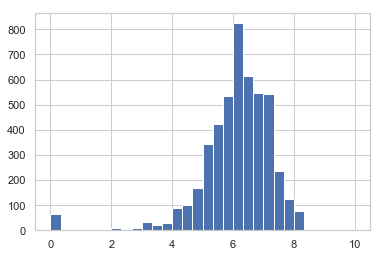

In [96]:
plt.hist(df_movies['vote_average'],bins=30)
plt.show()

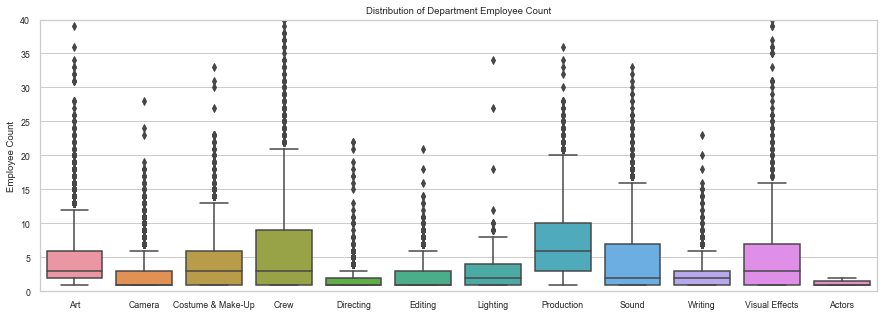

In [43]:
# Plot 1 Boxplot
sns.set(style='whitegrid', font_scale=.8)
ax = plt.figure(figsize=(15, 5))
ax = sns.boxplot(x='department', y='department_employee_count', data=output_department)
ax.set(xlabel='', ylabel='Employee Count')
plt.ylim(0, 40)
#sns.plt.xlim(0, None)

plt.title("Distribution of Department Employee Count")
plt.show()

In [37]:
output_department = df_parsed.groupby(['movie_id','title','department']).count()['credit_id'].reset_index()
output_department.rename(columns={'credit_id':'department_employee_count'}, inplace=True)
output_department = output_department.set_index(['movie_id', 'title'])
print(output_department.head(10))

                            department  department_employee_count
movie_id title                                                   
5        Four Rooms                Art                         10
         Four Rooms             Camera                          8
         Four Rooms  Costume & Make-Up                          7
         Four Rooms               Crew                         16
         Four Rooms          Directing                          7
         Four Rooms            Editing                          7
         Four Rooms           Lighting                          3
         Four Rooms         Production                         14
         Four Rooms              Sound                         12
         Four Rooms            Writing                          4


In [44]:
output_jobs = df_output.groupby(['movie_id','title','job']).count()['credit_id'].reset_index()
output_jobs.rename(columns={'credit_id':'job_employee_count'}, inplace=True)
output_jobs = output_jobs.set_index(['movie_id', 'title'])
print(output_jobs.head(10))

                                            job  job_employee_count
movie_id title                                                     
5        Four Rooms  Art Department Coordinator                   1
         Four Rooms               Art Direction                   1
         Four Rooms           Best Boy Electric                   1
         Four Rooms               Boom Operator                   1
         Four Rooms                   Carpenter                   1
         Four Rooms                     Casting                   1
         Four Rooms           Casting Associate                   1
         Four Rooms               Choreographer                   1
         Four Rooms                 Co-Producer                   3
         Four Rooms                 Color Timer                   1


In [73]:
data= output_jobs.reset_index().groupby(['job']).count()['title'].sort_values()
data = data.reset_index()

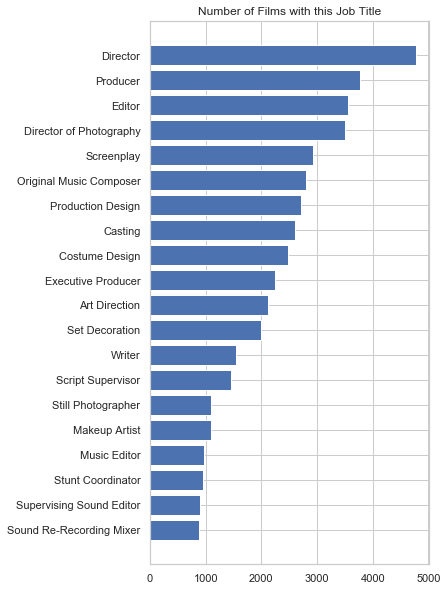

In [92]:
#data= output_jobs.reset_index().groupby(['job']).count()['title'].sort_values(ascending=False)
#plt.bar(data, height='title')
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(5, 10))
# Make fake dataset
height = data.iloc[-20:,1] # title which is number of movies with the position
bars = data.iloc[-20:,0] # name of the job
y_pos = np.arange(len(bars))
 
# Create horizontal bars
plt.barh(y_pos, height)
 
# Create names on the y-axis
plt.yticks(y_pos, bars)
plt.title('Number of Films with this Job Title')
# Show graphic
plt.show()


In [ ]:
movies_with_jobs = df_output.groupby(['job']).count()['title'].reset_index()

In [52]:
output_jobs.sort_values(by='job_employee_count', ascending=False).iloc[:,0:20]

job  \
movie_id title                                                                             
752      V for Vendetta                                                           Stunts   
863      Toy Story 2                                                           Animation   
13053    Bolt                                                                  Animation   
135397   Jurassic World                                                           Stunts   
         Jurassic World                                                      Compositors   
585      Monsters, Inc.                                                        Animation   
2749     15 Minutes                                                               Driver   
106646   The Wolf of Wall Street                                                  Stunts   
291270   Anomalisa                                                             Animation   
9473     South Park: Bigger, Longer & Uncut                                    Animation   
77174    ParaNorman                                                            Animation   
2749     15 Minutes                                                               Stunts   
14836    Coraline                                                              Animation   
408      Snow White and the Seven Dwarfs                                       Animation   
7443     Chicken Run                                                           Animation   
49026    The Dark Knight Rises                                                    Stunts   
533      The Curse of the Were-Rabbit                                          Animation   
72105    Ted                                                                   Animation   
9378     Thir13en Ghosts                                                  Makeup Effects   
72197    The Pirates! In an Adventure with Scientists!                         Animation   
11353    Bowfinger                                                                Stunts   
1547     The Lost Boys                                                            Stunts   
8836     The X Files: I Want to Believe                                      Compositors   
128      Princess Mononoke                                                     Animation   
98566    Teenage Mutant Ninja Turtles                                          Animation   
170687   The Boxtrolls                                                         Animation   
10315    Fantastic Mr. Fox                                                     Animation   
10895    Pinocchio                                                             Animation   
9297     Monster House                                                         Animation   
3933     Corpse Bride                                                          Animation   
...                                                                                  ...   
8920     Garfield                                                                 Author   
8916     Antz                                                  Visual Effects Supervisor   
8922     Jeepers Creepers                                                     Dolly Grip   
8916     Antz                                                 Visual Effects Coordinator   
         Antz                                                             Visual Effects   
         Antz                                           Systems Administrators & Support   
         Antz                                             Supervising Technical Director   
         Antz                                                   Supervising Sound Editor   
         Antz                                                       Supervising Animator   
         Antz                                                                 Storyboard   
8922     Jeepers Creepers                                                 ADR Supervisor   
         Jeepers Creepers            

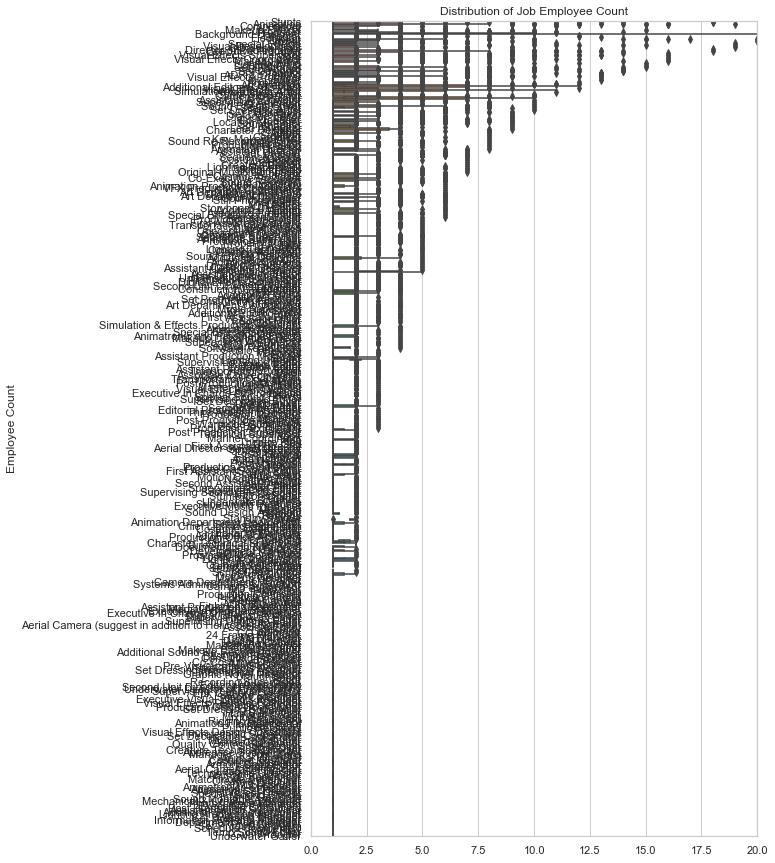

In [51]:
data = output_jobs.sort_values(by='job_employee_count', ascending=False).iloc[,]
sns.set(style='whitegrid', font_scale=1)
ax = plt.figure(figsize=(8, 15))
ax = sns.boxplot(y='job', x='job_employee_count', 
                 data=)
ax.set(xlabel='', ylabel='Employee Count')
#plt.ylim(0, 20)
plt.xlim(0, 20)

plt.title("Distribution of Job Employee Count")
plt.show()

In [21]:
df_parsed.sort_values(by='job').groupby(['job', 'department']).count().head()

,,movie_id,credit_id
job,department,,
24 Frame Playback,Visual Effects,14,14
2D Artist,Visual Effects,5,5
2D Supervisor,Visual Effects,4,4
3D Animator,Visual Effects,23,23
3D Artist,Visual Effects,35,35


In [48]:
department = []
unique_jobs = []

for x in df_parsed.department.unique():
    department.append(x)
    unique_jobs.append(len(df_parsed.groupby('department')['job'].unique()[x]))

department_values = pd.DataFrame(data = {'department':department, 'unique_jobs':unique_jobs})
print(department_values)
    

           department  unique_jobs
0             Editing           16
1                 Art           38
2               Sound           49
3          Production           35
4           Directing           12
5             Writing           25
6      Visual Effects           50
7   Costume & Make-Up           37
8              Camera           26
9                Crew          123
10           Lighting           19
11             Actors            1


In [47]:
df_parsed.department.unique()

array(['Editing', 'Art', 'Sound', 'Production', 'Directing', 'Writing',
       'Visual Effects', 'Costume & Make-Up', 'Camera', 'Crew',
       'Lighting', 'Actors'], dtype=object)

In [37]:
print("Number of Unique Departments: {}".format(len(df_parsed.department.unique())))
print("\nNumber of Unique Jobs: {}".format(len(df_parsed.job.unique())))

Number of Unique Departments:12

Number of Unique Jobs: 418


In [ ]:
df_department_counts = df_parse.pivot_table(index=['movie_id'], 
                                             columns=['department'], 
                                             aggfunc='count', 
                                             fill_value=0)['credit_id']

df_department_counts = df_department_counts.join(df_movies, how='left', on='movie_id')

print(df_department_counts.head())